In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from time import time
import pandas as pd
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

%matplotlib inline
sns.set_style("darkgrid")

In [2]:
# plot a nicely formatted confusion matrix
def plot_heatmap(df,title="Confusion Matrix \nnormed by pred (accuracy)"):
    sns.set(font_scale=1.2) #increase font size
    plt.figure(figsize=(8,7))

    # improve readability by hiding annotations for small values
    cm = pd.DataFrame(confusion_matrix(df.label, df.pred, normalize="pred"))
    for col in cm.columns:
        cm[col] = cm[col].apply(lambda x: "" if x <=.01 else str(round(x,2)))

    heatmap = sns.heatmap(
        data=confusion_matrix(df.label, df.pred, normalize="pred"),
        annot=cm, fmt="",
        cmap="viridis",
        linewidths=1.0,
        vmax=1,vmin=0,
        xticklabels=["T-shirt", 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'],
        yticklabels=["T-shirt", 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'])
    heatmap.xaxis.tick_top()
    heatmap.tick_params(length=0)
    plt.xticks(rotation = 45)
    plt.yticks(rotation=0)
    plt.title(title)
    plt.savefig(f"heatmap{title[:3]}.png", bbox_inches="tight")
    plt.show()

# Dataset and problem description

In this project, I seek to build an image classification model for the Fashion-MNIST dataset.  The Fashion-MNIST dataset is designed to replace the famous MNIST handwritten digit dataset as an image classification benchmark, so it is a substantially more challenging dataset.  The dataset contains images of 10 categories of clothing: T-shirts, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots.  So while this classification task is designed to be difficult, it is still a "real-world" dataset rather than an arbitrarily tough synthetic dataset.

Because the task is difficult, it is a good opportunity to explore the use of unsupervised learning techniques in conjunction with supervised models.  For each model that I attempt, I will compare performance with and without linear dimensionality reduction pre-processing techniques (PCA/TruncatedSVD).


Citation:
*Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. arXiv:1708.07747*
*https://github.com/zalandoresearch/fashion-mnist*

In [3]:
#full dataset available at https://www.kaggle.com/datasets/zalando-research/fashionmnist/download
#training dataset exceeds github's max upload size
df_train = pd.read_csv("fashion-mnist_train.csv")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


---
# EDA

As shown by the plots below, all features are already on the same scale (0-255).  The labels are already balanced (6000 samples per label).

There are no missing values, so we don't need to worry about data cleaning.  Because the labels are balanced, we can use accuracy as our performance metric when evaluating models.

<AxesSubplot:>

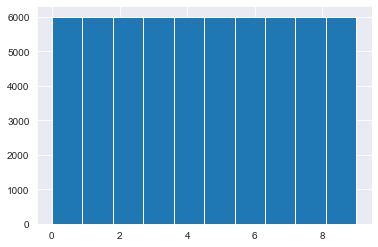

In [4]:
# check to see if labels are balanced
df_train.label.hist()

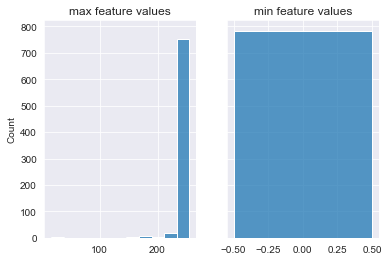

In [5]:
# verify that features are on the same scale
fig,axs = plt.subplots(1,2,sharey=True)
max_vals = np.array(df_train.iloc[:,1:]).max(axis=0)
sns.histplot(max_vals, ax=axs[0]); axs[0].set_title("max feature values")
min_vals = np.array(df_train.iloc[:,1:]).min(axis=0)
sns.histplot(min_vals, ax=axs[1]); axs[1].set_title("min feature values")
plt.show()

In [6]:
# dict for mapping label number to name
label_lookup = {0:"T-shirt",1: 'Trouser',2: 'Pullover',3: 'Dress',4: 'Coat',5: 'Sandal',6: 'Shirt',7: 'Sneaker',8: 'Bag',9: 'Ankle boot'}

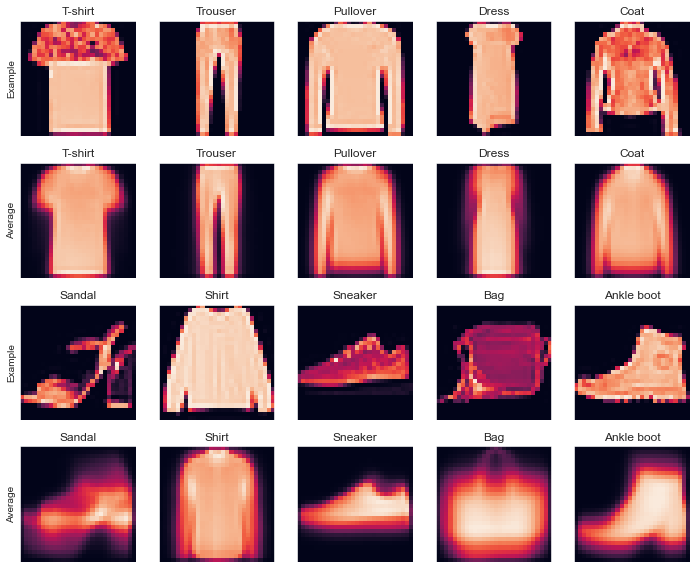

In [7]:
def show_example_images(df):
    items = []
    mean_items = []

    for i in range(10):
        item = df[df.label == i].sample(n=1, random_state=1).drop(columns="label")
        img_item = np.array(item).reshape((28,28))
        items.append(img_item)

        mean_item = np.mean(df[df.label == i].drop(columns="label"), axis=0)
        img_mean_item = np.array(mean_item).reshape((28,28))
        mean_items.append(img_mean_item)

    fig, axs = plt.subplots(nrows=4,ncols=5, sharey="row", sharex="col", figsize=(12,10))
    for i, img in enumerate(items[:5]):
        axs[0,i].imshow(img); axs[0,i].set_title(label_lookup[i]); axs[0,i].grid(None)
    for i, img in enumerate(mean_items[:5]):
        axs[1,i].imshow(img); axs[1,i].set_title(label_lookup[i]); axs[1,i].grid(None)
    for i, img in enumerate(items[5:]):
        axs[2,i].imshow(img); axs[2,i].set_title(label_lookup[i+5]); axs[2,i].grid(None)
    for i, img in enumerate(mean_items[5:]):
        axs[3,i].imshow(img); axs[3,i].set_title(label_lookup[i+5]); axs[3,i].grid(None)
    fig.axes[0].set_ylabel("Example"); fig.axes[0].set_yticks([])
    fig.axes[5].set_ylabel("Average"); fig.axes[5].set_yticks([])
    fig.axes[10].set_ylabel("Example"); fig.axes[10].set_yticks([])
    fig.axes[15].set_ylabel("Average"); fig.axes[15].set_yticks([])
    for x in range(5):
        fig.axes[x].set_xticks([])
    plt.savefig("image_grid.png", bbox_inches='tight')
    plt.show()
show_example_images(df_train)

The previous graphic shows an example from each of the 10 labels as well as the "average item" for each feature.  To display the image, the vector representations of each image were reshaped into a 28x28 grid.

The similarity between the **average shirt**, **average coat**, and **average pullover** is immediately apparent.  Perhaps surprisingly, the averages for the 3 types of footwear are not very similar. From this visual representation, it should be no surprise that distinguishing between shirts, coats, and pullovers is the most challenging part of this classification task.

---
# Unsupervised learning models

#### Clustering (Agglomerative Clustering & KMeans)
In this project I will use a variety of unsupervised learning techniques.  2 of these techniques -- Agglomerative Clustering and KMeans clustering -- are clustering algorithms which can potentially complete classification on their own, even without training labels.  However, these clustering techniques are only well-suited for datasets that have distinct clusters -- or can be transformed into a space with distinct clusters -- which correspond to different labels.

Both clustering methods' runtimes scale poorly with the number of samples (items), so I'll use a smaller sample of the dataset.  Both clustering methods can be susceptible to "the curse of dimensionality", so I'll try the models with and without dimensionality reduction techniques.

In a truly unsupervised scenario where we didn't have labeled data, we would need to find a performant plan for matching clusters to labels.  Since we *do* have access to the true labels, I will use the true labels to identify what each cluster likely represents.  This method is be faster than manually or iteratively matching clusters to labels.


#### Decomposition (PCA & TruncatedSVD)
I will use **principal component analysis** (PCA) and **truncated singular value decomposition** (SVD) throughout this project. These unsupervised techniques allow us to reduce the dimensionality of the dataset while retaining the vast majority of the dataset's variance.  This can be particularly useful as a pre-processing step before using models that are vulnerable to the "curse of dimensionality" -- like many distance-based models.  Also, these techniques can be extremely useful for models that assume features are uncorrelated, because PCA/SVD yields uncorrelated components.

As shown below, we can use these two techniques to reduce the number of feature dimension from 784 to 84 while maintaining 90% of the variance or to 187 while maintaining 95% of the variance.

Note: Sklearn's implementation of Truncated SVD and PCA are virtually identical except that the data is automatically centered for PCA but not for SVD.  Centering the data can be helpful, but comes at the cost of removing zeroes from this relatively sparse dataset.

In [8]:
pca_ev = PCA(n_components=300, random_state=1).fit(df_train.iloc[:,1:]).explained_variance_ratio_
print( f"{np.where(np.cumsum(pca_ev) >.9)[0][0] +1} components contain 90% of the variance " )
print( f"{np.where(np.cumsum(pca_ev) > .95)[0][0] +1} components contain 95% of the variance " )

84 components contain 90% of the variance 
187 components contain 95% of the variance 


## AgglomerativeClustering
Agglomerative Clustering's results are entirely deterministic, but dependent on the **affinity** and **linkage** hyperparameters.  We'll search through these parameter pairings to find the most performant combination.

In [9]:
#function we'll use for AgglomerativeClustering and Kmeans to match clusters with labels
def determine_cluster_labels(df, n_clusters=10):
    """
    :param df: dataframe with true labels in column named "label" and clusters in column named "pred"
    :return: returns df with "cluster" re-coded to match the majority known (training) label of that cluster
    """
    cluster_to_label = dict(zip(list(range(10)), [None]*10))
    for cluster in range(n_clusters):
        majority_label = df[df.pred == cluster].mode(axis=0)["label"][0]
        cluster_to_label[cluster] = int(majority_label)
    df["pred"] = df["pred"].apply(lambda x: cluster_to_label[x])

    return df

In [10]:
# evaluate linkage-distance parameter pairings to find best performance
# prints the best linkage/distance parameter pairing and the best accuracy
# plots confusion matrix of the most accurate model.
def aggcluster_param_search(df_to_cluster):
    """
    :param df_to_cluster: dataframe with true labels in column named "label"
    """
    affinities = ["euclidean", "l1", "l2", "manhattan", "cosine"]
    linkages = ["complete", "average"] # `single` not included because it was consistently terrible
    params = list(itertools.product(affinities, linkages)) # cartesian product of affinities and linkages
    params.append(("euclidean", "ward")) # NOTE: ward linkage requires euclidean affinity

    best_params = (None, None)
    best_acc = 0.0
    best_df = None

    t = time()
    for p in params:
        model = AgglomerativeClustering(
            n_clusters=10,
            affinity = p[0],
            linkage = p[1]).fit(df_to_cluster.drop(columns="label"))
        df_temp = df_to_cluster.copy(deep=True)
        df_temp["pred"] = model.labels_
        df_temp = determine_cluster_labels(df_temp)
        acc_temp = accuracy_score(df_temp.label, df_temp.pred)

        if acc_temp > best_acc:
            best_acc = acc_temp
            best_params = p
            best_df = df_temp.copy(deep=True)

    print(f"fit runtime: {round((time()-t)/60 ,2)} minutes")
    print(f"best model: \n acc = {best_acc} \n linkage: {best_params[1]} \n distance metric: {best_params[0]}")
    plot_heatmap(best_df, title="AggCluster {euclidean, ward} \nnormed by pred (accuracy)")
    return None

In [11]:
#computing clusters on the full training dataset takes a really long time, so we'll try it on a smaller sample instead
df_sample_cl = df_train.sample(frac=.1, random_state=1)

fit runtime: 1.94 minutes
best model: 
 acc = 0.5685 
 linkage: ward 
 distance metric: euclidean


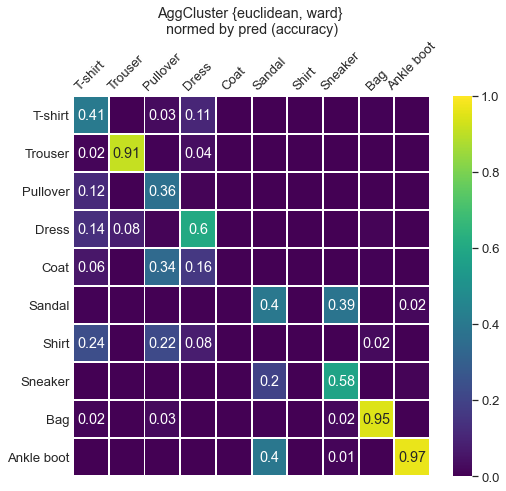

In [12]:
aggcluster_param_search(df_sample_cl)

Even the best Agglomerative Clustering model performed poorly (accuracy=0.5685).  As we can see from the confusion matrix, the model was unable to distinguish between pullovers, coats, and shirts.  The model was  quite accurate for the "easy" labels -- bags, ankle boots, and trousers.

Before we move on, I'll try running the Agglomerative Clustering model on data with reduced number of feature dimensions (through PCA and SVD)

In [13]:
def plot_dim_red_aggcluster(df, affinity="euclidean", linkage="ward", max_dims=40):
    df_aggclust_results = pd.DataFrame({
        "n_components":list(range(5,max_dims+5,5)),
        "svd_acc":[0]*len(list(range(5,max_dims+5,5))),
        "pca_acc":[0]*len(list(range(5,max_dims+5,5)))})

    X=df.drop(columns="label")

    #baseline data (no dimension reduction)
    df_temp = df.copy(deep=True)
    df_temp["pred"] = AgglomerativeClustering(n_clusters=10,affinity=affinity,linkage=linkage).fit_predict(X)
    df_temp = determine_cluster_labels(df_temp)
    acc_temp = accuracy_score(df_temp.label, df_temp.pred)
    df_aggclust_results["none"] = [acc_temp]*len(list(range(5,max_dims+5,5)))

    for i, n in enumerate(df_aggclust_results.n_components):
        #truncated svd
        X_temp=TruncatedSVD(n_components=n).fit_transform(X)
        model=AgglomerativeClustering(n_clusters=10,affinity=affinity,linkage=linkage).fit(X_temp)
        df_temp = df.copy(deep=True)
        df_temp["pred"] = model.labels_
        df_temp = determine_cluster_labels(df_temp)
        acc_temp = accuracy_score(df_temp.label, df_temp.pred)
        df_aggclust_results.iloc[i,1] = acc_temp

        #pca
        X_temp = PCA(n_components=n).fit_transform(X)
        model=AgglomerativeClustering(n_clusters=10,affinity=affinity,linkage=linkage).fit(X_temp)
        df_temp = df.copy(deep=True)
        df_temp["pred"] = model.labels_
        df_temp = determine_cluster_labels(df_temp)
        acc_temp = accuracy_score(df_temp.label, df_temp.pred)
        df_aggclust_results.iloc[i,2] = acc_temp
        # print(f"n = {n} complete")

    print(f"best Agglomerative Clustering accuracy: {np.array(df_aggclust_results.iloc[:,1:]).max()}")
    plt.figure(figsize=(8,4))
    plt.plot(df_aggclust_results["n_components"], df_aggclust_results["svd_acc"], label="svd")
    plt.plot(df_aggclust_results["n_components"], df_aggclust_results["pca_acc"], label="pca")
    plt.plot(df_aggclust_results["n_components"], df_aggclust_results["none"], label="baseline (no D.R.)")
    plt.legend()
    plt.xlabel("n_components"); plt.ylabel("accuracy")
    plt.title(f"params: {affinity}, {linkage}")
    plt.savefig("AggClust.png", bbox_inches='tight')
    plt.show()

best Agglomerative Clustering accuracy: 0.6403333333333333


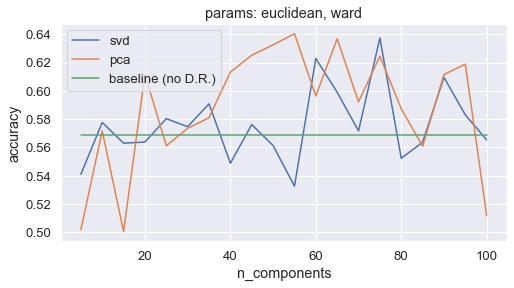

runtime: 2.42 minutes


In [14]:
t0 = time()
plot_dim_red_aggcluster(df_sample_cl,max_dims=100)
print(f"runtime: {round((time()-t0)/60,2)} minutes")

The previous plot shows that dimensionality reduction was helpful... sometimes.

There were instances that SVD and PCA yielded improvements (max accuracy = 0.64), but other instances where they reduced the accuracy of the model.  There is no clear pattern to the number of components vs. accuracy, which casts doubt on PCA/SVD's usefulness as a pre-processing step for this model.

Overall, Agglomerative Clustering was not successful, which may suggest that the data's natural clusters contain heterogenous labels.

## KMeans
The failure of Agglomerative Clustering suggests that KMeans may struggle.  However, KMeans is more susceptible than AggClustering to the curse of dimensionality, so it's worth seeing how PCA/SVD may impact KMeans performance.

In [15]:
def plot_dim_red_kmeans(df, max_dims=200):
    """
    :param df: DataFrame with true labels in column "label"
    """

    df_kmeans_results = pd.DataFrame({
        "n_components":list(np.arange(10,max_dims+10,10)),
        "svd_acc":[0]*len(list(np.arange(10,max_dims+10,10))),
        "pca_acc":[0]*len(list(np.arange(10,max_dims+10,10)))})
    #Baseline accuracy
    df_temp = df.copy()
    df_temp["pred"] = KMeans(n_clusters=10, n_init=20, random_state=1).fit_predict(df.drop(columns=["label"]))
    df_temp = determine_cluster_labels(df_temp)
    df_kmeans_results["none"] = [accuracy_score(df_temp.label, df_temp.pred)]*len(list(np.arange(10,max_dims+10,10)))

    for i, n in enumerate(df_kmeans_results.n_components):
        #SVD
        X_temp=TruncatedSVD(n_components=n).fit_transform(df.drop(columns=["label"]))
        df_temp = df.copy()
        df_temp["pred"] = KMeans(n_clusters=10, n_init=20,random_state=1).fit_predict(X_temp)
        df_temp = determine_cluster_labels(df_temp)
        df_kmeans_results.iloc[i,1] = accuracy_score(df_temp.label, df_temp.pred)

        #PCA
        X_temp=PCA(n_components=n).fit_transform(df.drop(columns=["label"]))
        df_temp = df.copy()
        df_temp["pred"] = KMeans(n_clusters=10, n_init=20, random_state=1).fit_predict(X_temp)
        df_temp = determine_cluster_labels(df_temp)
        df_kmeans_results.iloc[i,2] = accuracy_score(df_temp.label, df_temp.pred)

    print(f"best KMeans accuracy: {np.array(df_kmeans_results.iloc[:,1:]).max()}")
    plt.figure(figsize=(8,4))
    plt.plot(df_kmeans_results["n_components"], df_kmeans_results["svd_acc"], label="svd")
    plt.plot(df_kmeans_results["n_components"], df_kmeans_results["pca_acc"], label="pca")
    plt.plot(df_kmeans_results["n_components"], df_kmeans_results["none"], label="Baseline (No D.R.)")
    plt.legend()
    plt.xlabel("n_components"); plt.ylabel("accuracy")
    plt.title("Accuracy for KMeans model \n(after dimensionality reduction techniques)")
    plt.savefig("KMeans.png", bbox_inches='tight')
    plt.show()

best KMeans accuracy: 0.6085


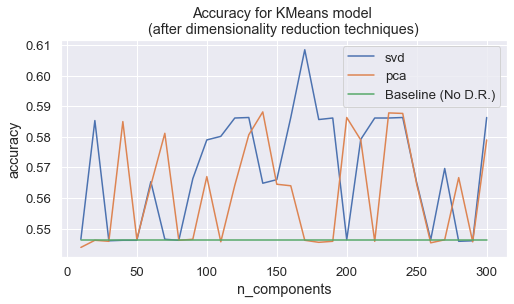

runtime: 3.01 minutes


In [16]:
t0=time()
plot_dim_red_kmeans(df_sample_cl, max_dims=300)
print(f"runtime: {round((time()-t0)/60,2)} minutes")

The best KMeans model had poor accuracy (0.61) but (unlike AggClustering), PCA and SVD improved the accuracy in many cases while rarely decreasing performance.

Note that the KMeans algorithm is highly influenced by the starting location of centroids, so it's possible that these results are influenced by noise.

#### Unsupervised learning conclusion:
Overall, these unsupervised models were not very effective.  This suggests that the dataset didn't have distinct enough clusters, and that linear dimensionality techniques were of limited effectiveness.

It is possible that a non-linear dimension reduction technique such as t-SNE would have better results since it may provide better distinction between clusters of similarly shaped items.

---
# Supervised models

Since the unsupervised models were unsuccessful, I'll try supervised models and see how PCA/SVD improves (or harms) their performance for this classification task.

Specifically, I'll try: **Gaussian Naive Bayes** classifier(GNB), **support vector classifier** (SVC), and **random forest classifier** (RFC).

## GaussianNB

GaussianNB models aren't generally used for image classification tasks, but it's an interesting model to play around with when examining the impact of PCA.  It is reasonable to suspect that it will be out-performed by the SVC and RFC, so this model would be safe to skip if our only goal was to "win a Kaggle competition."

In [17]:
def plot_dim_red_GNB(df, max_dims=180):
    X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,1:], df.label, test_size=.2, random_state=1)

    df_gnb_results = pd.DataFrame({
        "n_components":list(range(5,max_dims+5,5)),
        "svd_acc":[0]*len(list(range(5,max_dims+5,5))),
        "pca_acc":[0]*len(list(range(5,max_dims+5,5))),
        "none":[GaussianNB().fit(X_train,y_train).score(X_val,y_val)]*len(list(range(5,max_dims+5,5)))})

    for i, n in enumerate(df_gnb_results.n_components):
        #SVD without centering
        svd=TruncatedSVD(n_components=n).fit(X_train)
        X_train_, X_val_ = svd.transform(X_train), svd.transform(X_val)
        gnb_temp=GaussianNB().fit(X_train_,y_train)
        df_gnb_results.iloc[i,1] = gnb_temp.score(X_val_, y_val)

        #pca
        pca=PCA(n_components=n).fit(X_train)
        X_train_, X_val_ = pca.transform(X_train), pca.transform(X_val)
        gnb_temp=GaussianNB().fit(X_train_,y_train)
        df_gnb_results.iloc[i,2] = gnb_temp.score(X_val_, y_val)

    print(f"best GaussianNB training accuracy: {np.array(df_gnb_results.iloc[:,1:]).max()}")
    plt.figure(figsize=(8,4))
    plt.plot(df_gnb_results["n_components"], df_gnb_results["svd_acc"], label="svd")
    plt.plot(df_gnb_results["n_components"], df_gnb_results["pca_acc"], label="pca")
    plt.plot(df_gnb_results["n_components"], df_gnb_results["none"], label="Baseline (No D.R.)")
    plt.legend()
    plt.xlabel("n_components"); plt.ylabel("accuracy")
    plt.title("Validation accuracy for GaussianNB \n(after dimensionality reduction techniques)")
    plt.savefig("GNB.png", bbox_inches='tight')
    plt.show()

best GaussianNB training accuracy: 0.7801666666666667


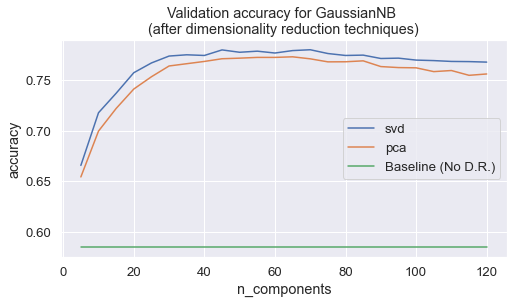

runtime: 1.74 minutes


In [18]:
t0 = time()
plot_dim_red_GNB(df_train, max_dims=120)
print(f"runtime: {round((time()-t0)/60,2)} minutes")

The GNB was quite poor when using the raw data (acc = 0.59), but PCA/SVD yielded an *enormous* increase in accuracy (acc = .78).

This is likely due to the fact that GNB assumes that features are uncorrelated and independent.  In practice, this assumption is rarely met with real datasets, but PCA/SVD yield components that are uncorrelated. The elimination of collinearity is likely explanation for the GNB performance improvement.  Because SVD consistently outperformed PCA, we can conclude that centering the data hurt the model's performance.

## SVC

Before trying an SVC model, there are a few important considerations related to the model's runtime.
* SVC runtime scales poorly with sample size, so we'll use a smaller sample of the training dataset.
* SVC is known to work best with centered data, so I'll use PCA and skip SVD to keep the runtime manageable


In [19]:
def plot_dim_red_svc(df, max_dims=100):
    df_svc_results = pd.DataFrame({
        "n_components":np.arange(10,max_dims+5,step=5),
        "pca_acc": [0]*len(np.arange(10,max_dims+5,step=5))
    })

    # SVC runtime scales poorly with n_samples, so we'll only use a portion of the available training data
    df_sample=df.sample(n=20000, random_state=1)
    X_train, X_val, y_train, y_val = train_test_split(df_sample.iloc[:,1:], df_sample.label, test_size=.2, random_state=1)

    # baseline
    svc_temp = SVC(kernel="rbf", random_state=1).fit(X_train, y_train)
    df_svc_results["none"] = [svc_temp.score(X_val,y_val)] * df_svc_results.shape[0]

    #StandardScaler
    scaler=StandardScaler().fit(X_train)
    X_train_, X_val_ =scaler.transform(X_train), scaler.transform(X_val)
    svc_temp = SVC(kernel="rbf", random_state=1).fit(X_train_, y_train)
    df_svc_results["Std.Scaler"] = [svc_temp.score(X_val_,y_val)] * df_svc_results.shape[0]

    for i, n in enumerate(df_svc_results.n_components):
        #PCA
        pca_temp = PCA(n_components=n, whiten=True, random_state=1).fit(X_train)
        X_train_, X_val_ = pca_temp.transform(X_train), pca_temp.transform(X_val)
        svc_temp = SVC(kernel="rbf", random_state=1).fit(X_train_, y_train)
        df_svc_results.iloc[i,1] = svc_temp.score(X_val_,y_val)

    print( f"best SVC accuracy: {np.array(df_svc_results.iloc[:,1:]).max()}")
    plt.figure(figsize=(8,4))
    plt.plot(df_svc_results["n_components"], df_svc_results["Std.Scaler"], label="Std.Scaler")
    plt.plot(df_svc_results["n_components"], df_svc_results["pca_acc"], label="pca")
    plt.plot(df_svc_results["n_components"], df_svc_results["none"], label="baseline (no D.R.)")
    plt.legend()
    plt.xlabel("n_components"); plt.ylabel("accuracy")
    plt.title("Validation accuracy for SVC \n(after dimensionality reduction techniques)")
    plt.savefig("SVC.png", bbox_inches='tight')
    plt.show()


best SVC accuracy: 0.88225


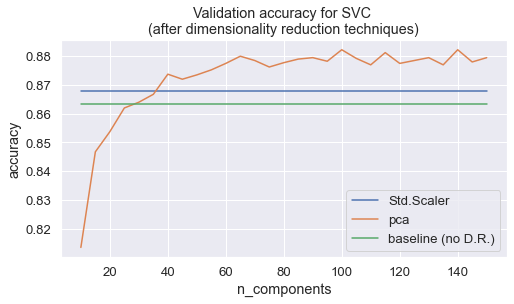

runtime: 6.84 minutes


In [20]:
t0 = time()
plot_dim_red_svc(df_train, max_dims=150)
print(f"runtime: {round((time()-t0)/60,2)} minutes")

The SVC performed quite well (best acc = 0.882), especially compared to the previous models.

The SVC performed well even with raw, uncentered data (acc > 0.86).  As expected, it performed better with data that was centered and standardized to unit variance.

Most of the improvement from using PCA can be attributed to removing collinearity, although as previously mentioned, centering the data helped a little.  Notably, the reduced dimensionality was not helpful on its own.  Perhaps this shouldn't be surprising, given that the entire concept of Support Vector Machines is to map the data to a high dimensional space.

Note that we could probably squeeze out additional performance if we thoroughly searched hyperparameter combinations.  But my limited testing with sklearn's GridSearchCV (~1hour runtime) showed that the default parameters for C and gamma worked very well, and additional testing didn't seem like a good use of time in the context of this project.

## RFC

Random Forest Models aren't affected by multicollinearity, curse of dimensionality, or anything else that PCA/SVD can alleviate.  So there's no real reason to suspect that PCA/SVD will improve the model's performance.

validation acc: 0.8835833333333334


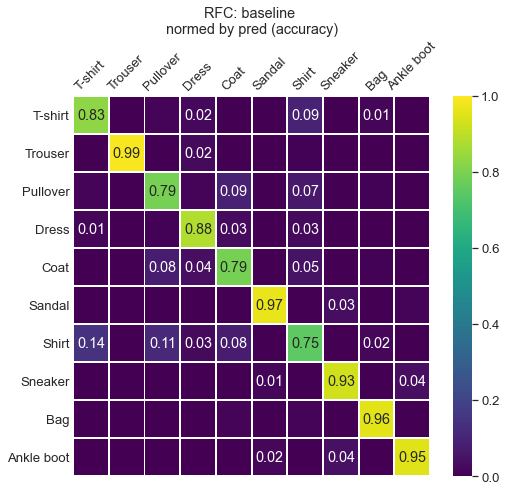

In [21]:
X_train, X_val, y_train, y_val = train_test_split(df_train.iloc[:,1:], df_train.label, test_size=.2, random_state=1)
rfc_baseline = RandomForestClassifier(n_estimators=200,random_state=1, n_jobs=-1)
rfc_baseline.fit(X_train,y_train)
df_pred_baseline = pd.DataFrame(data={"label":y_val}, columns=["label"])
df_pred_baseline["pred"] = rfc_baseline.predict(X_val)

print(f"validation acc: {accuracy_score(df_pred_baseline.label, df_pred_baseline.pred)}")
plot_heatmap(df_pred_baseline, "RFC: baseline \nnormed by pred (accuracy)")

The RFC had the best accuracy (0.884) of any model so far, and didn't need any preprocessing to do it.  The confusion matrix shows that it struggled with the same categories that the clustering models did, although it performed better overall.

For the sake of completeness, lets look at the impact of PCA/SVD on the RFC performance.

In [22]:
def plot_dim_red_rfc(df, n_estimators = 100, max_dims=180):
    X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,1:], df.label, test_size=.2, random_state=1)

    df_rfc_results = pd.DataFrame({
        "n_components":list(range(5,max_dims+5,5)),
        "svd_acc":[0]*len(list(range(5,max_dims+5,5))),
        "pca_acc":[0]*len(list(range(5,max_dims+5,5))),})

    # no dimension reduction
    rfc_temp=RandomForestClassifier(n_estimators=n_estimators, random_state=1, n_jobs=-1).fit(X_train,y_train)
    df_rfc_results["none"] = [rfc_temp.score(X_val,y_val)]*len(list(range(5,max_dims+5,5)))

    for i, n in enumerate(df_rfc_results.n_components):
        #SVD without centering
        svd=TruncatedSVD(n_components=n).fit(X_train)
        X_train_, X_val_ =svd.transform(X_train), svd.transform(X_val)
        rfc_temp=RandomForestClassifier(n_estimators=n_estimators, random_state=1, n_jobs=-1).fit(X_train_,y_train)
        df_rfc_results.iloc[i,1] = rfc_temp.score(X_val_, y_val)

        #pca
        pca=PCA(n_components=n).fit(X_train)
        X_train_, X_val_ = pca.transform(X_train), pca.transform(X_val)
        rfc_temp=RandomForestClassifier(n_estimators=n_estimators, random_state=1, n_jobs=-1).fit(X_train_,y_train)
        df_rfc_results.iloc[i,2] = rfc_temp.score(X_val_, y_val)

    print(f"best RFC accuracy: {np.array(df_rfc_results.iloc[:,1:]).max()}")
    plt.figure(figsize=(8,4))
    plt.plot(df_rfc_results["n_components"], df_rfc_results["svd_acc"], label="svd")
    plt.plot(df_rfc_results["n_components"], df_rfc_results["pca_acc"], label="pca")
    plt.plot(df_rfc_results["n_components"], df_rfc_results["none"], label="Baseline (No D.R.)")
    plt.legend()
    plt.xlabel("n_components"); plt.ylabel("accuracy")
    plt.title("Validation accuracy for RandomForestClassifier \n(after dimensionality reduction techniques)")
    plt.savefig("RFC.png", bbox_inches='tight')
    plt.show()

best RFC accuracy: 0.878


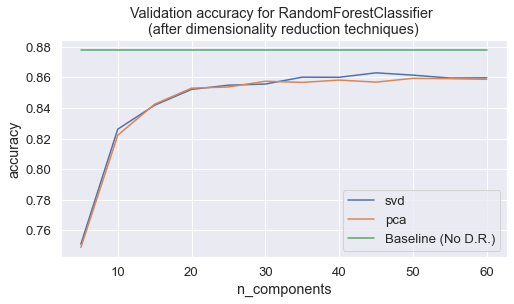

runtime: 1.34 minutes


In [23]:
t0 = time()
plot_dim_red_rfc(df_train, n_estimators = 50, max_dims=60)
print(f"runtime: {round((time()-t0)/60,2)} minutes")

The RFC performed worse following PCA/SVD.

This shouldn't be surprising, because RFCs are inherently robust against the effects of multi-collinearity and "the curse of dimensionality."  Therefore, the RFC has little to gain from PCA/SVD but still pays the price for PCA/SVD removing a (small) portion of the variance.



---
# Summary of Results

<br>

| model    | best acc  | PCA/SVD helpful? |
|----------|-----------|------------------|
| AggClust | 0.64      | unclear          |
| KMeans   | 0.61      | yes              |
| GNB      | 0.78      | yes              |
| SVC      | 0.882     | yes              |
| **RFC**  | **0.884** | no               |

---
# Conclusion

This dataset was challenging for all models, which makes it a great benchmark for testing different pre-processing techniques.  **We saw that pipelines with PCA/SVD pre-processing are often an improvement over using raw data; however, the effect of PCA/SVD pre-processing is highly dependent on the classifier.**  In some cases, such as the RFC, this preprocessing *decreases* performance; therefore, PCA/SVD shouldn't be used blindly.

In general, PCA/SVD is likely to be useful in conjunction with models that struggle with multi-collinearity and/or high feature dimensionality.  Models that are already robust against multi-collinearity and high feature dimensionality are likely to lose accuracy.  Keep in mind that small decrease in accuracy may be an acceptable tradeoff in situations where dimensionality reduction substantially improves the model's runtime or memory consumption.




